<a href="https://colab.research.google.com/github/preetamjumech/Avila_DataSet_AdaBoost-GradientBoost-XGboost/blob/main/AML_Preetam_Saha_C22018_avila_dataset_part2_29_05_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We present an analysis of the Avila dataset, which contains features extracted from 800 images of the Avila Bible (Biblia de Ávila), a giant Latin copy of the Bible produced during the XII century between Italy and Spain (De Stefano, 2018).
Each record of the dataset containts 11 attributes pertaining to a group of 4 consecutive rows of the tome averaged together. We refer to each group of 4 rows as a pattern. The attributes of a pattern represent several palaeographic characteristics that were inferred from a digital scan of each page. Rubricated letters and miniatures were excluded from the scans.
The palaeographic analysis performed on the Avila Bible established that the manuscript contains pages written by 12 different scribe monks throughout the years. The goal of this analysis is to identify which scribe is the author of a certain pattern based on the available attributes. This makes the task a classification problem in which the copyist monk constitutes the class to predict.

To shorten computation times and to ease the illustation of the behavior of certain algorithms, we restrict our analysis to the patterns associated to 6 out of the 12 scribes. According to the available documentation, the attributes of dataset have already been standardized. A short description of the available attributes follows.

Attributes description
Page level features:
intercolumnar distance: distance between two columns of a page
upper margin: distance between upper margin of the page and first line of text
lower margin: distance between lower margin of the page and last line of text
Column level features:
exploitation: fraction of the column filled with ink. Formally computed as 
, where 
 and 
 are the number of black pixels and the number of total pixels in the current column, respectively.
row number: number of rows in the current column
Row level features:
modular ratio: estimation of the dimension of the handwritten character
interlinear spacing: distance between two rows, in pixels
weight: fraction of row filled with ink. Analogous to exploitation, but for a single row
peak number: estimation of the number of characters in a row
modular ratio/ interlinear spacing: ratio of the two preceding attributes
All attributes are quantitative (i.e. numerical). The target variable is assigned the name monk; it is the only qualitative attribute of the dataset. Each copyist is denoted with a different letter.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"]=[15,10]
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from itertools import combinations
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, cohen_kappa_score, make_scorer

In [ ]:
df_train=pd.read_csv("avila-tr.txt",header=None)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.266074,-0.165620,0.320980,0.483299,0.172340,0.273364,0.371178,0.929823,0.251173,0.159345,A
1,0.130292,0.870736,-3.210528,0.062493,0.261718,1.436060,1.465940,0.636203,0.282354,0.515587,A
2,-0.116585,0.069915,0.068476,-0.783147,0.261718,0.439463,-0.081827,-0.888236,-0.123005,0.582939,A
3,0.031541,0.297600,-3.210528,-0.583590,-0.721442,-0.307984,0.710932,1.051693,0.594169,-0.533994,A
4,0.229043,0.807926,-0.052442,0.082634,0.261718,0.148790,0.635431,0.051062,0.032902,-0.086652,F


In [ ]:
df_train.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
dtype: int64

In [ ]:
df_train[10].value_counts()

A    4286
F    1961
E    1095
I     831
X     522
H     519
G     446
D     352
Y     266
C     103
W      44
B       5
Name: 10, dtype: int64

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10430 entries, 0 to 10429
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       10430 non-null  float64
 1   1       10430 non-null  float64
 2   2       10430 non-null  float64
 3   3       10430 non-null  float64
 4   4       10430 non-null  float64
 5   5       10430 non-null  float64
 6   6       10430 non-null  float64
 7   7       10430 non-null  float64
 8   8       10430 non-null  float64
 9   9       10430 non-null  float64
 10  10      10430 non-null  object 
dtypes: float64(10), object(1)
memory usage: 896.5+ KB


In [ ]:
df_train.describe()

,0,1,2,3,4,5,6,7,8,9
count,10430.000000,10430.000000,10430.000000,10430.000000,10430.000000,10430.000000,10430.000000,10430.000000,10430.000000,10430.000000
mean,0.000852,0.033611,-0.000525,-0.002387,0.006370,0.013973,0.005605,0.010323,0.012914,0.000818
std,0.991431,3.920868,1.120202,1.008527,0.992053,1.126245,1.313754,1.003507,1.087665,1.007094
min,-3.498799,-2.426761,-3.210528,-5.440122,-4.922215,-7.450257,-11.935457,-4.247781,-5.486218,-6.719324
25%,-0.128929,-0.259834,0.064919,-0.528002,0.172340,-0.598658,-0.044076,-0.541991,-0.372457,-0.516097
50%,0.043885,-0.055704,0.217845,0.095763,0.261718,-0.058835,0.220177,0.111803,0.064084,-0.034513
75%,0.204355,0.203385,0.352988,0.658210,0.261718,0.564038,0.446679,0.654944,0.500624,0.530855
max,11.819916,386.000000,50.000000,3.987152,1.066121,53.000000,83.000000,13.173081,44.000000,4.671232


In [ ]:
df_train.corr().unstack().sort_values(ascending=False).drop_duplicates()

0  0    1.000000
5  9    0.755992
1  6    0.582443
8  7    0.487543
5  6    0.462871
4  0    0.451966
5  1    0.424384
2  1    0.414578
1  8    0.349011
7  3    0.338970
9  3    0.323915
6  2    0.289165
3  8    0.281239
8  4    0.274883
6  8    0.272458
   9    0.263015
3  5    0.257627
8  5    0.214207
   2    0.193194
9  8    0.186226
4  9    0.151590
2  3    0.143608
   5    0.132723
4  3    0.096426
0  8    0.059427
6  3    0.043915
7  1    0.041227
5  4    0.039824
7  2    0.034970
2  0    0.034473
6  4    0.026447
4  2    0.011333
7  6    0.002444
1  3    0.002026
6  0   -0.001173
9  0   -0.002839
7  9   -0.016045
9  1   -0.024810
0  1   -0.037577
7  0   -0.043336
0  5   -0.044663
9  2   -0.045392
7  5   -0.059628
0  3   -0.065338
4  1   -0.067759
7  4   -0.071220
dtype: float64

In [ ]:
df_test=pd.read_csv("avila-ts.txt",header=None)
df_test.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-3.498799,0.250492,0.232070,1.224178,-4.922215,1.145386,0.182426,-0.165983,-0.123005,1.087144,W
1,0.204355,-0.354049,0.320980,0.410166,-0.989576,-2.218127,0.220177,0.181844,2.090879,-2.009758,A
2,0.759828,-1.304042,-0.023991,-0.973663,-0.006417,-0.349509,-0.421580,-0.450127,0.469443,0.060952,I
3,-0.005490,0.360409,0.281860,-0.213479,-1.168333,-1.013906,-0.346080,1.176165,0.968347,-0.627999,E
4,0.080916,0.101320,0.104040,0.140490,0.261718,0.480988,0.710932,-0.253430,-0.497183,0.155681,A


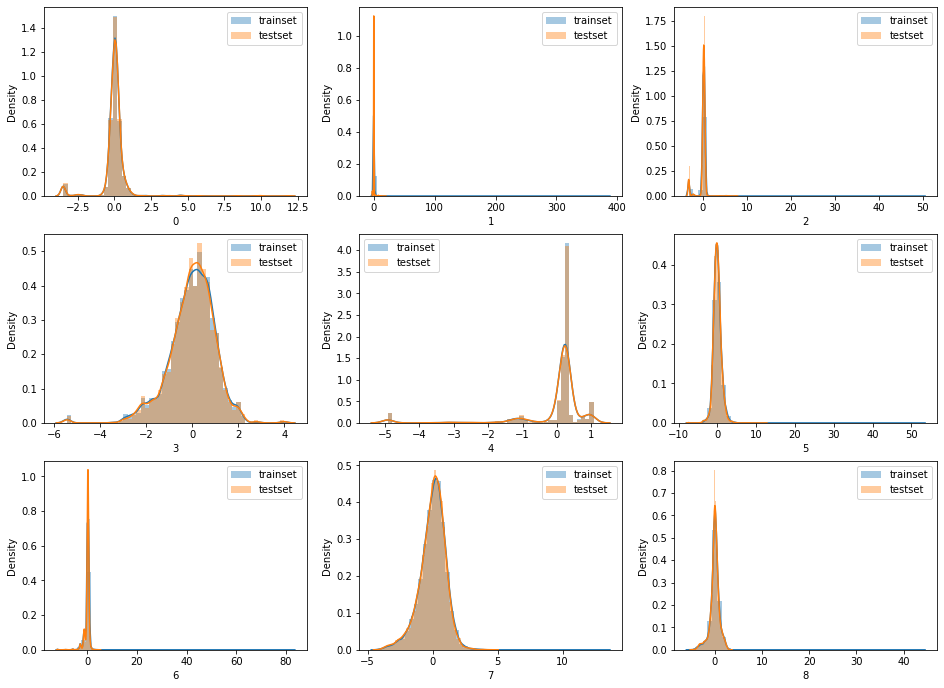

In [ ]:
plt.figure(figsize=(16,16))
for k in range(9):
    plt.subplot(4,3,k+1)
    sns.distplot(df_train.iloc[:,k], label='trainset')
    sns.distplot(df_test.iloc[:,k], label='testset')
    plt.legend()

In [ ]:
from sklearn.metrics import SCORERS

In [ ]:
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [ ]:
### mapping non-linearity by DT REGRESSOR

In [ ]:
dt = DecisionTreeRegressor(max_depth=10)

In [ ]:
score=[]
for i , j in combinations(range(9),2):
  cv_score=cross_val_score(dt,X=np.array(df_train.iloc[:,i]).reshape(-1,1),y=df_train.iloc[:,j],cv=5,scoring='neg_median_absolute_error').mean()
  print(f"{i} and {j} has cv_score {np.round(cv_score,4)}")
  score.append(cv_score)
print(np.round(score,4))
np.argmin(np.abs(np.round(score,4)))

0 and 1 has cv_score -0.2213
0 and 2 has cv_score -0.2131
0 and 3 has cv_score -0.5105
0 and 4 has cv_score -0.1236
0 and 5 has cv_score -0.5306
0 and 6 has cv_score -0.2716
0 and 7 has cv_score -0.5926
0 and 8 has cv_score -0.4298
1 and 2 has cv_score -0.1823
1 and 3 has cv_score -0.5587
1 and 4 has cv_score -0.2427
1 and 5 has cv_score -0.5603
1 and 6 has cv_score -0.3226
1 and 7 has cv_score -0.5906
1 and 8 has cv_score -0.4593
2 and 3 has cv_score -0.5323
2 and 4 has cv_score -0.1692
2 and 5 has cv_score -0.5611
2 and 6 has cv_score -0.3156
2 and 7 has cv_score -0.5821
2 and 8 has cv_score -0.4436
3 and 4 has cv_score -0.1598
3 and 5 has cv_score -0.4972
3 and 6 has cv_score -0.2855
3 and 7 has cv_score -0.5053
3 and 8 has cv_score -0.4163
4 and 5 has cv_score -0.5671
4 and 6 has cv_score -0.2384
4 and 7 has cv_score -0.5951
4 and 8 has cv_score -0.4504
5 and 6 has cv_score -0.3203
5 and 7 has cv_score -0.5626
5 and 8 has cv_score -0.425
6 and 7 has cv_score -0.6027
6 and 8 has cv_

3

In [ ]:
np.abs(score)

array([0.22130666, 0.21313326, 0.5104702 , 0.12357362, 0.53063084,
       0.27162585, 0.59262408, 0.42979538, 0.18230718, 0.55874243,
       0.24274158, 0.56025004, 0.32259493, 0.59061333, 0.45929376,
       0.53233284, 0.16918724, 0.56110673, 0.31561202, 0.58211641,
       0.44356114, 0.15975774, 0.49716751, 0.2855381 , 0.50525666,
       0.41628284, 0.56713863, 0.23840028, 0.59506472, 0.45035642,
       0.32033428, 0.56256065, 0.42502895, 0.60273476, 0.44152044,
       0.37954023])

In [ ]:
np.min(np.abs(score))

0.12357361573618852

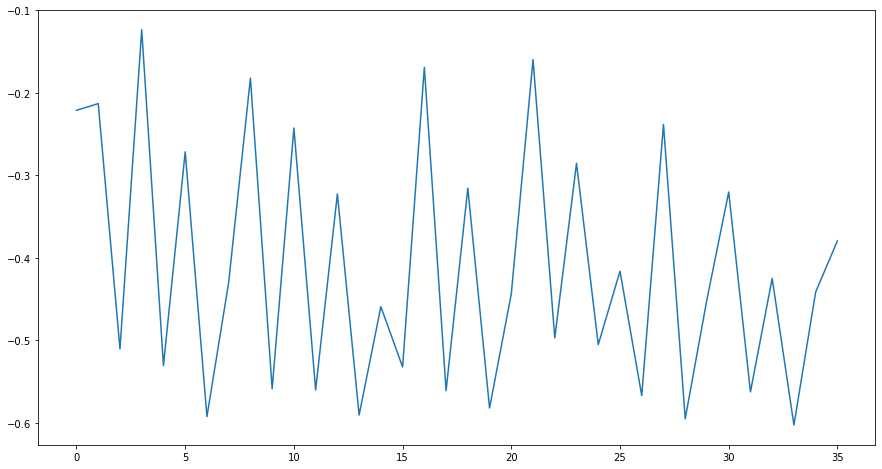

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(score)

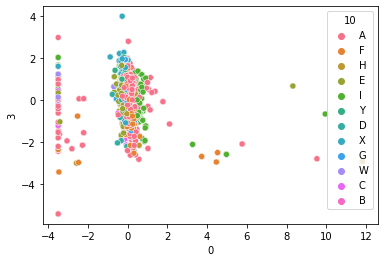

In [ ]:
sns.scatterplot(data = df_train, x=df_train.iloc[:,0], 
                y=df_train.iloc[:,3], hue=10)

In [ ]:
X=df_train.iloc[:,1]
X

0       -0.165620
1        0.870736
2        0.069915
3        0.297600
4        0.807926
           ...   
10425    0.588093
10426   -0.338346
10427   -0.000745
10428    0.352558
10429   -1.037102
Name: 1, Length: 10430, dtype: float64

In [ ]:
X=np.array(df_train.iloc[:,1]).reshape(-1,1)
X

array([[-1.656200e-01],
       [ 8.707360e-01],
       [ 6.991500e-02],
       ...,
       [-7.450000e-04],
       [ 3.525580e-01],
       [-1.037102e+00]])

In [ ]:
### mapping non-linearity by KNN REGRESSOR with k=5 WITH NEGATIVE MEDIAN ABSOLUTE ERROR

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
knn_reg=make_pipeline(StandardScaler(),
                          KNeighborsRegressor(n_neighbors=5))

In [ ]:
score=[]
for i , j in combinations(range(9),2):
  cv_score=cross_val_score(knn_reg,X=np.array(df_train.iloc[:,i]).reshape(-1,1),y=df_train.iloc[:,j],cv=5,scoring='neg_median_absolute_error').mean()
  print(f"{i} and {j} has cv_score {np.round(cv_score,4)}")
  score.append(cv_score)
print(np.round(score,4))
np.argmin(np.abs(np.round(score,4)))

0 and 1 has cv_score -0.2344
0 and 2 has cv_score -0.1881
0 and 3 has cv_score -0.5366
0 and 4 has cv_score -0.118
0 and 5 has cv_score -0.6079
0 and 6 has cv_score -0.3307
0 and 7 has cv_score -0.6501
0 and 8 has cv_score -0.5126
1 and 2 has cv_score -0.1218
1 and 3 has cv_score -0.5113
1 and 4 has cv_score -0.1466
1 and 5 has cv_score -0.6046
1 and 6 has cv_score -0.3503
1 and 7 has cv_score -0.6399
1 and 8 has cv_score -0.5232
2 and 3 has cv_score -0.5098
2 and 4 has cv_score -0.0983
2 and 5 has cv_score -0.6046
2 and 6 has cv_score -0.3526
2 and 7 has cv_score -0.6214
2 and 8 has cv_score -0.5222
3 and 4 has cv_score 0.0
3 and 5 has cv_score -0.4601
3 and 6 has cv_score -0.2658
3 and 7 has cv_score -0.4859
3 and 8 has cv_score -0.3642
4 and 5 has cv_score -0.6063
4 and 6 has cv_score -0.3166
4 and 7 has cv_score -0.6361
4 and 8 has cv_score -0.4665
5 and 6 has cv_score -0.3609
5 and 7 has cv_score -0.6361
5 and 8 has cv_score -0.5532
6 and 7 has cv_score -0.662
6 and 8 has cv_score

21

In [ ]:
cv_score

-0.44277695999999994

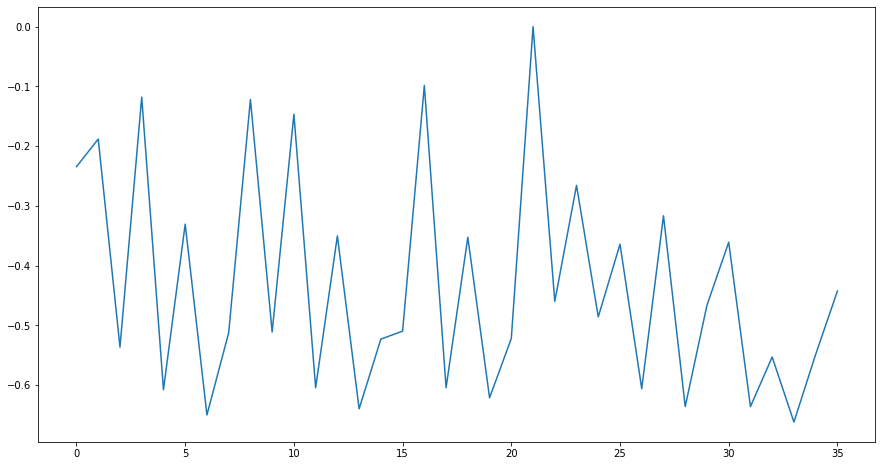

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(score)

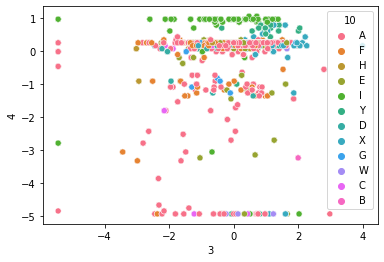

In [ ]:
sns.scatterplot(data = df_train, x=df_train.iloc[:,3], 
                y=df_train.iloc[:,4], hue=10)

In [ ]:
### mapping non-linearity with DT REG with NEGATIVE ROOT MEAN SQUARED ERROR

In [ ]:
score=[]
for i , j in combinations(range(9),2):
  cv_score=cross_val_score(dt,X=np.array(df_train.iloc[:,i]).reshape(-1,1),y=df_train.iloc[:,j],cv=5,scoring='neg_root_mean_squared_error').mean()
  print(f"{i} and {j} has cv_score {np.round(cv_score,4)}")
  score.append(cv_score)

0 and 1 has cv_score -2.4936
0 and 2 has cv_score -1.0148
0 and 3 has cv_score -0.8359
0 and 4 has cv_score -0.5213
0 and 5 has cv_score -1.0366
0 and 6 has cv_score -1.2048
0 and 7 has cv_score -0.9673
0 and 8 has cv_score -0.9688
1 and 2 has cv_score -1.0061
1 and 3 has cv_score -0.9086
1 and 4 has cv_score -0.86
1 and 5 has cv_score -1.0944
1 and 6 has cv_score -1.2742
1 and 7 has cv_score -0.986
1 and 8 has cv_score -1.0554
2 and 3 has cv_score -0.8933
2 and 4 has cv_score -0.8666
2 and 5 has cv_score -1.0679
2 and 6 has cv_score -1.2331
2 and 7 has cv_score -0.9633
2 and 8 has cv_score -1.0337
3 and 4 has cv_score -0.7109
3 and 5 has cv_score -0.9859
3 and 6 has cv_score -1.2205
3 and 7 has cv_score -0.8667
3 and 8 has cv_score -0.9516
4 and 5 has cv_score -1.0558
4 and 6 has cv_score -1.1693
4 and 7 has cv_score -0.9814
4 and 8 has cv_score -0.9987
5 and 6 has cv_score -1.2557
5 and 7 has cv_score -0.9765
5 and 8 has cv_score -1.0501
6 and 7 has cv_score -1.0209
6 and 8 has cv_sc

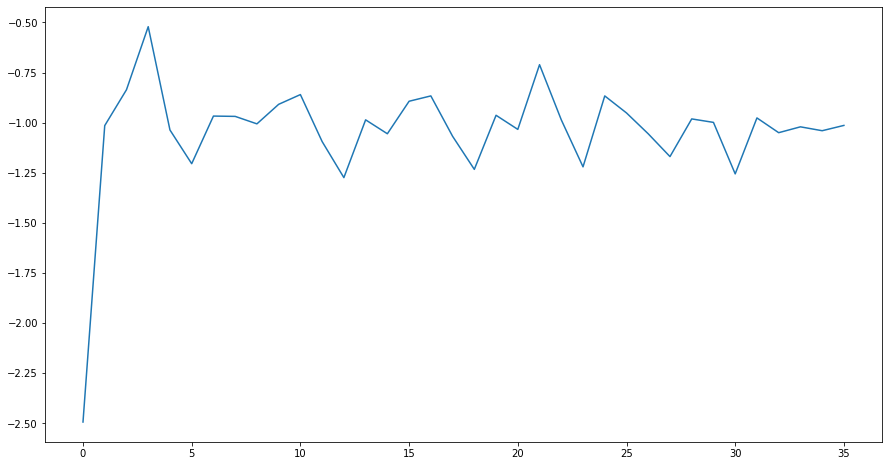

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(score)

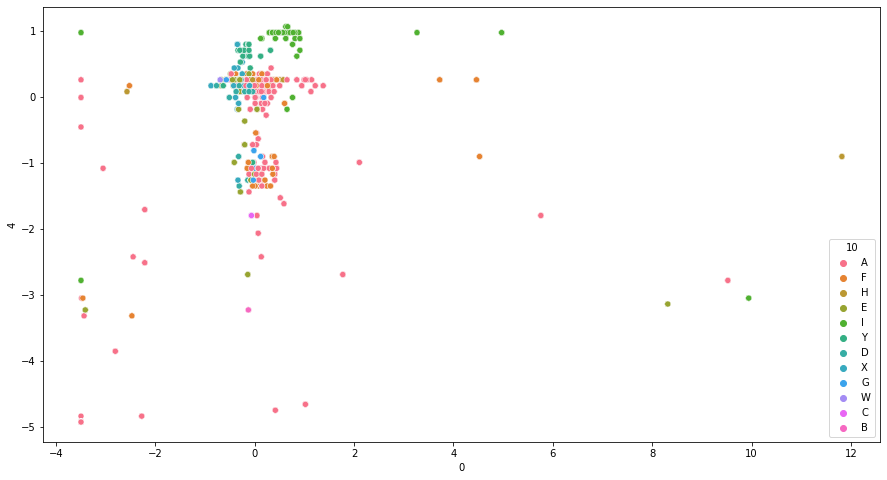

In [ ]:
plt.figure(figsize=(15,8))
sns.scatterplot(data = df_train, x=df_train.iloc[:,0], 
                y=df_train.iloc[:,4], hue=10)

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb = XGBClassifier(n_estimators=3000, max_depth=1, 
                    learning_rate=0.01, booster='gbtree')

In [ ]:
xgb.fit(df_train.iloc[:,:-1],df_train.iloc[:,-1])

XGBClassifier(learning_rate=0.01, max_depth=1, n_estimators=3000,
              objective='multi:softprob')

In [ ]:
df_train.iloc[:,:-1]

,0,1,2,3,4,5,6,7,8,9
0,0.266074,-0.165620,0.320980,0.483299,0.172340,0.273364,0.371178,0.929823,0.251173,0.159345
1,0.130292,0.870736,-3.210528,0.062493,0.261718,1.436060,1.465940,0.636203,0.282354,0.515587
2,-0.116585,0.069915,0.068476,-0.783147,0.261718,0.439463,-0.081827,-0.888236,-0.123005,0.582939
3,0.031541,0.297600,-3.210528,-0.583590,-0.721442,-0.307984,0.710932,1.051693,0.594169,-0.533994
4,0.229043,0.807926,-0.052442,0.082634,0.261718,0.148790,0.635431,0.051062,0.032902,-0.086652
...,...,...,...,...,...,...,...,...,...,...
10425,0.080916,0.588093,0.015130,0.002250,0.261718,-0.557133,0.371178,0.932346,0.282354,-0.580141
10426,0.253730,-0.338346,0.352988,-1.154243,0.172340,-0.557133,0.257927,0.348428,0.032902,-0.527134
10427,0.229043,-0.000745,0.171611,-0.002793,0.261718,0.688613,0.295677,-1.088486,-0.590727,0.580142
10428,-0.301743,0.352558,0.288973,1.638181,0.261718,0.688613,0.069175,0.502761,0.625350,0.718969


In [ ]:
df_train.iloc[:,-1]

0        A
1        A
2        A
3        A
4        F
        ..
10425    F
10426    F
10427    A
10428    E
10429    X
Name: 10, Length: 10430, dtype: object

In [ ]:
### cohen kappa

In [ ]:
from sklearn.metrics import cohen_kappa_score

In [ ]:
cohen_kappa_score(df_test.iloc[:,-1],xgb.predict(df_test.iloc[:,:-1]))

0.6704581464333796

In [ ]:
cv_score=cross_val_score(xgb,df_test.iloc[:,:-1],df_test.iloc[:,-1],scoring=make_scorer(cohen_kappa_score),cv=5,n_jobs=-1)

In [ ]:
cv_score

array([0.65969896, 0.67896569, 0.67026109, 0.68352469, 0.64729249])

In [ ]:
cv_score.mean()

0.6679485852287477

In [ ]:
### confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [ ]:
pred = xgb.predict(df_test.iloc[:,:-1])

In [ ]:
pd.DataFrame(confusion_matrix(df_test.iloc[:,10],pred))

,0,1,2,3,4,5,6,7,8,9,10,11
0,3847,0,0,31,115,229,32,29,1,0,2,0
1,0,4,0,0,0,0,0,0,0,0,1,0
2,30,0,46,0,18,9,0,0,0,0,0,0
3,32,0,0,252,53,9,0,6,0,0,1,0
4,181,0,0,21,785,39,10,44,1,0,13,1
5,1054,0,0,0,22,839,25,22,0,0,0,0
6,120,0,0,0,10,32,277,8,0,0,0,0
7,125,0,0,0,10,21,13,351,0,0,0,0
8,14,0,0,0,0,1,0,0,809,2,1,5
9,12,0,0,0,0,0,0,0,0,32,1,0


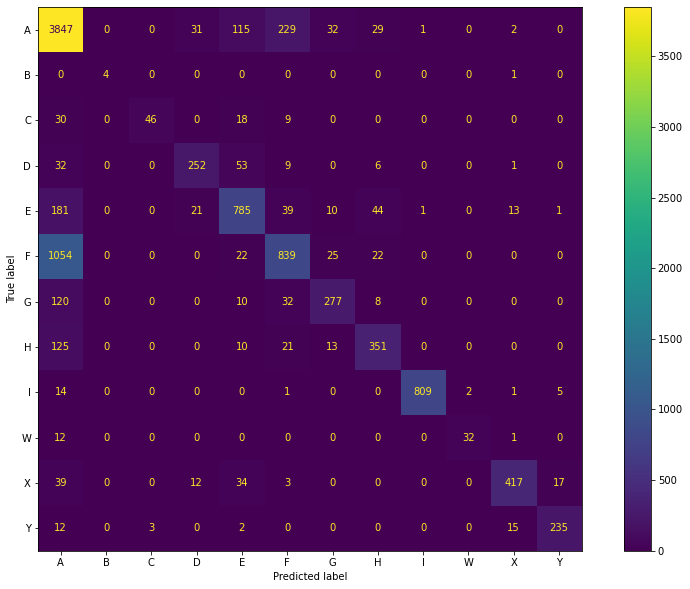

In [ ]:
#plt.figure(figsize=(25,12))
cm=confusion_matrix(df_test.iloc[:,10],pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=xgb.classes_)
disp.plot()
plt.show()

In [ ]:
### categorical cross entropy

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lgr = LogisticRegression(random_state=42)

In [ ]:
lgr.fit(df_train.iloc[:,:-1],df_train.iloc[:,-1])

LogisticRegression(random_state=42)

In [ ]:
lgr.predict(df_test.iloc[:,:-1])

array(['W', 'X', 'I', ..., 'A', 'A', 'A'], dtype=object)

In [ ]:
lgr.score(df_test.iloc[:,:-1],df_test.iloc[:,-1])

0.5608891443901505

In [ ]:
lgr.predict_proba(df_test.iloc[:,:-1])

array([[1.83209332e-01, 9.92511574e-04, 3.69434161e-03, ...,
        3.92506575e-01, 1.98155872e-01, 2.40846783e-02],
       [2.05421206e-02, 3.75643220e-04, 1.05805140e-02, ...,
        6.12723351e-05, 4.96491511e-01, 3.37153536e-03],
       [9.21337494e-02, 1.28827235e-04, 9.85282950e-03, ...,
        1.43469612e-05, 3.21690062e-03, 6.83126986e-04],
       ...,
       [6.28925576e-01, 2.38946704e-04, 5.32223565e-03, ...,
        3.25514883e-03, 2.45173389e-03, 1.58614119e-03],
       [3.48188434e-01, 4.39933836e-04, 1.76383293e-02, ...,
        4.65614624e-04, 7.92492773e-04, 1.33730020e-02],
       [2.78549369e-01, 3.07582157e-04, 1.66371672e-02, ...,
        3.47046074e-04, 1.99410400e-03, 7.59517411e-03]])

In [ ]:
xgb = XGBClassifier(n_estimators=3000, max_depth=1, 
                    learning_rate=0.01, booster='gbtree')

In [ ]:
xgb.fit(df_train.iloc[:,:-1],df_train.iloc[:,-1])

XGBClassifier(learning_rate=0.01, max_depth=1, n_estimators=3000,
              objective='multi:softprob')

In [ ]:
xgb.predict(df_test.iloc[:,:-1])

array(['W', 'X', 'I', ..., 'A', 'F', 'H'], dtype=object)

In [ ]:
pred=xgb.predict_proba(df_test.iloc[:,:-1])

In [ ]:
pred

array([[3.57696623e-01, 6.74503535e-05, 1.15742011e-03, ...,
        5.69414318e-01, 1.34424847e-02, 6.00467110e-03],
       [3.02706867e-01, 2.65928596e-04, 2.10878160e-03, ...,
        2.10295038e-04, 5.44125259e-01, 6.91035436e-03],
       [4.63087350e-01, 2.92907248e-06, 1.22880680e-03, ...,
        1.48765748e-05, 8.90149735e-03, 1.10214890e-03],
       ...,
       [3.75260532e-01, 4.26015722e-05, 6.29960618e-04, ...,
        2.47017364e-04, 8.93659948e-04, 3.18040280e-03],
       [2.42322788e-01, 3.27921703e-06, 6.62550854e-04, ...,
        1.01548314e-04, 3.36002733e-04, 1.83503167e-03],
       [2.97184795e-01, 2.35380912e-06, 2.64060247e-04, ...,
        2.72351113e-04, 8.38360225e-04, 1.17380382e-03]], dtype=float32)

In [ ]:
pred[0]

array([3.5769662e-01, 6.7450354e-05, 1.1574201e-03, 9.0917846e-04,
       3.3284046e-02, 1.1482230e-02, 4.6475921e-03, 4.5620417e-04,
       1.4377646e-03, 5.6941432e-01, 1.3442485e-02, 6.0046711e-03],
      dtype=float32)

In [ ]:
-np.log(pred[0])

array([1.0280701 , 9.604118  , 6.761562  , 7.0029693 , 3.402677  ,
       4.4669547 , 5.371406  , 7.69257   , 6.544666  , 0.56314695,
       4.309335  , 5.1152177 ], dtype=float32)

In [ ]:
xgb.predict_proba(df_test.iloc[:,:-1])[0]

array([3.5769662e-01, 6.7450354e-05, 1.1574201e-03, 9.0917846e-04,
       3.3284046e-02, 1.1482230e-02, 4.6475921e-03, 4.5620417e-04,
       1.4377646e-03, 5.6941432e-01, 1.3442485e-02, 6.0046711e-03],
      dtype=float32)

In [ ]:
xgb.predict_proba(df_test.iloc[:,:-1])[0].max()

0.5694143

In [ ]:
-np.log(0.5694143)

0.5631469902983037

In [ ]:
np.argmax(xgb.predict_proba(df_test.iloc[:,:-1])[0])

9

In [ ]:
df_test.iloc[0,-1]

'W'

In [ ]:
df_train[10]

0        A
1        A
2        A
3        A
4        F
        ..
10425    F
10426    F
10427    A
10428    E
10429    X
Name: 10, Length: 10430, dtype: object

In [ ]:
pd.get_dummies(df_train[10])

,A,B,C,D,E,F,G,H,I,W,X,Y
0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10425,0,0,0,0,0,1,0,0,0,0,0,0
10426,0,0,0,0,0,1,0,0,0,0,0,0
10427,1,0,0,0,0,0,0,0,0,0,0,0
10428,0,0,0,0,1,0,0,0,0,0,0,0


In [ ]:
df=pd.get_dummies(df_test[10])

In [ ]:
df

,A,B,C,D,E,F,G,H,I,W,X,Y
0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10432,0,0,0,0,0,0,0,0,0,0,1,0
10433,0,0,0,0,0,0,1,0,0,0,0,0
10434,1,0,0,0,0,0,0,0,0,0,0,0
10435,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
cce=-(df* np.log(pred))
cce

,A,B,C,D,E,F,G,H,I,W,X,Y
0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.563147,0.000000,0.0
1,1.194990,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.709541,0.000000,0.000000,0.0
3,0.000000,0.0,0.0,0.0,1.476097,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.324059,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10432,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.406722,0.0
10433,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.945158,0.000000,0.000000,0.000000,0.000000,0.0
10434,0.980135,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
10435,0.000000,0.0,0.0,0.0,0.000000,0.786296,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [ ]:
col_cce=cce.sum(axis=0)
col_cce

A    2108.763428
B       3.003357
C     151.306366
D     339.916748
E     989.283020
F    1991.318848
G     439.025360
H     473.599731
I      76.004639
W      39.699711
X     317.634857
Y     113.512123
dtype: float32

In [ ]:
total_cce=col_cce.sum()
total_cce

7043.0684

In [ ]:
def cat_cross_entropy_score(model,df_train,df_test):
  model=model.fit(df_train.iloc[:,:-1],df_train.iloc[:,-1])
  pred=model.predict_proba(df_test.iloc[:,:-1])
  dummy=pd.get_dummies(df_test.iloc[:,-1])
  df_cce=-(dummy*np.log(pred))
  col_sum_cce = df_cce.sum(axis=0)
  total_cce_score = col_sum_cce.sum()
  return total_cce_score

In [ ]:
from sklearn.linear_model import LogisticRegression
lgr=LogisticRegression()

In [ ]:
cat_cross_entropy_score(LogisticRegression(),df_train,df_test)

13772.119414561683

In [ ]:
from xgboost import XGBClassifier
xgb=XGBClassifier()

In [ ]:
cat_cross_entropy_score(xgb,df_train,df_test)

4225.608

In [ ]:
xgb1 = XGBClassifier(n_estimators=3000, max_depth=1, 
                    learning_rate=0.01, booster='gbtree')

In [ ]:
cat_cross_entropy_score(xgb1,df_train,df_test)

7043.0684

In [ ]:
### Stacking

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [ ]:
estimators = [('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
              ('svr', make_pipeline(StandardScaler(),
                          LinearSVC(random_state=42))),
              ('gbm',GradientBoostingClassifier(n_estimators=1000,random_state=42)),
              ('knn',make_pipeline(StandardScaler(),
                          KNeighborsClassifier(n_neighbors=3)))
]

In [ ]:
clf = StackingClassifier(estimators=estimators,final_estimator=XGBClassifier())

In [ ]:
clf.fit(df_train.iloc[:,:-1],df_train.iloc[:,-1])

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=42)),
                               ('svr',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('linearsvc',
                                                 LinearSVC(random_state=42))])),
                               ('gbm',
                                GradientBoostingClassifier(n_estimators=1000,
                                                           random_state=42)),
                               ('knn',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('kneighborsclassifier',
                                                 KNeighbo

In [ ]:
cohen_kappa_score(df_test.iloc[:,-1],clf.predict(df_test.iloc[:,:-1]))

0.9991288384174781

In [ ]:
cv_score=cross_val_score(clf,df_test.iloc[:,:-1],df_test.iloc[:,-1],scoring=make_scorer(cohen_kappa_score),cv=5,n_jobs=-1)

In [ ]:
cv_score

array([0.9968886 , 0.99751179, 0.99937766, 0.99750931, 0.99875522])

In [ ]:
cv_score.mean()

0.9980085148112753

In [ ]:
cat_cross_entropy_score(clf,df_train,df_test)

62.366905

In [ ]:
pred = clf.predict(df_test.iloc[:,:-1])

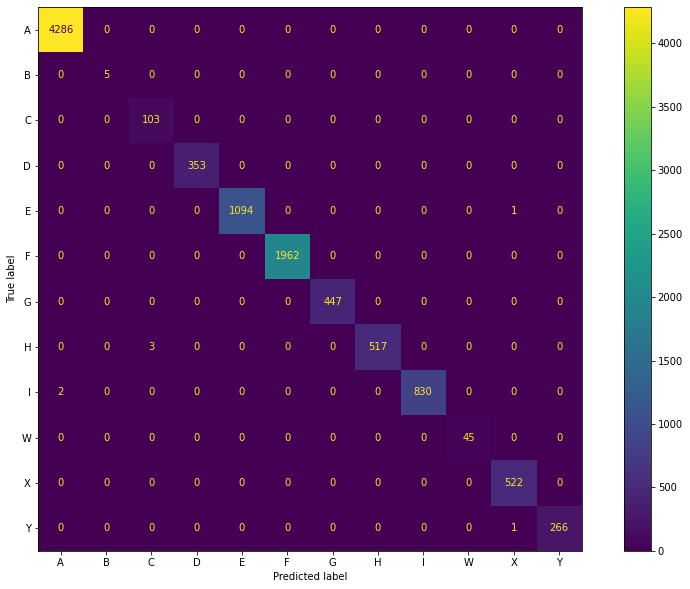

In [ ]:
#plt.figure(figsize=(25,12))
cm=confusion_matrix(df_test.iloc[:,10],pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

In [ ]:
### Bagging with KNN

In [ ]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
clf = BaggingClassifier(base_estimator=make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors=5)),
                         n_estimators=10, random_state=0).fit(df_train.iloc[:,:-1], df_train.iloc[:,-1])

In [ ]:
clf.predict(df_test.iloc[:,:-1])

array(['A', 'Y', 'F', ..., 'A', 'A', 'A'], dtype=object)

In [ ]:
clf.predict_proba(df_test.iloc[:,:-1])

array([[0.44, 0.  , 0.  , ..., 0.4 , 0.12, 0.  ],
       [0.26, 0.  , 0.  , ..., 0.  , 0.  , 0.32],
       [0.32, 0.  , 0.  , ..., 0.  , 0.08, 0.  ],
       ...,
       [0.54, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.4 , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.38, 0.  , 0.06, ..., 0.  , 0.  , 0.  ]])

In [ ]:
clf.predict_proba(df_test.iloc[:,:-1])[0]

array([0.44, 0.  , 0.  , 0.  , 0.04, 0.  , 0.  , 0.  , 0.  , 0.4 , 0.12,
       0.  ])

In [ ]:
clf.predict_proba(df_test.iloc[:,:-1])[1]

array([0.26, 0.  , 0.  , 0.12, 0.24, 0.  , 0.  , 0.06, 0.  , 0.  , 0.  ,
       0.32])

In [ ]:
clf.score(df_test.iloc[:,:-1],df_test.iloc[:,-1])

0.7416882245856089

In [ ]:
cat_cross_entropy_score(clf,df_train,df_test)

inf

In [ ]:
cohen_kappa_score(df_test.iloc[:,-1],clf.predict(df_test.iloc[:,:-1]))

0.6540665980286771

In [ ]:
cv_score=cross_val_score(clf,df_test.iloc[:,:-1],df_test.iloc[:,-1],scoring=make_scorer(cohen_kappa_score),cv=5,n_jobs=-1)

In [ ]:
cv_score.mean()

0.6394818458791458

In [ ]:
pred = clf.predict(df_test.iloc[:,:-1])

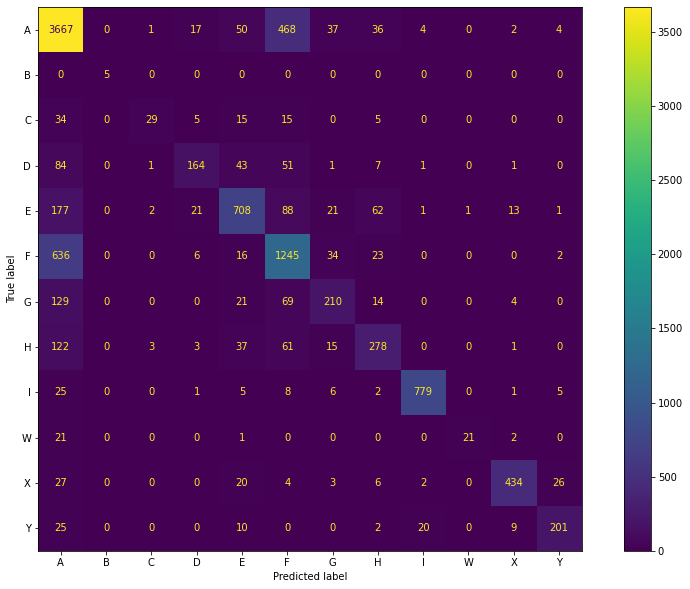

In [ ]:
cm=confusion_matrix(df_test.iloc[:,10],pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

In [ ]:
# hyperparameters with xgboost

In [ ]:
clf_xgb=XGBClassifier(objective="multi:softprob",random_state=42)
clf_xgb.fit(df_train.iloc[:,:-1],df_train.iloc[:,-1])

XGBClassifier(objective='multi:softprob', random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
def kappa(y_act, y_pred):
    return cohen_kappa_score(y_act, y_pred)

Kappa = make_scorer(kappa)

In [ ]:
param_grid = {
    'max_depth':[3,4,5],
    'learning_rate':[0.1,0.01,0.05],
    'gamma':[0,0.25,1.0],
    'reg_lambda':[0,1.0,10.0],
    'scale_pos_weight':[1,3,5]

}
optimal_params=GridSearchCV(
    estimator=XGBClassifier(
        objective="multi:softprob",
        seed=42,
        subsample=0.9,
        colsample_bytree=0.5),
        param_grid=param_grid,
        verbose=True,
        scoring=kappa,
        n_jobs=-1,
        cv=3
)

In [ ]:
optimal_params.fit(df_train.iloc[:,:-1],df_train.iloc[:,-1])
print(optimal_params.best_score_)
print(optimal_params.best_params_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
nan
{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 1}


In [ ]:
param_grid = {
    'max_depth':[1,2,3],
    'learning_rate':[0.05,0.1],
    'gamma':[0],
    'reg_lambda':[0],
    'scale_pos_weight':[1]

}
optimal_params=GridSearchCV(
    estimator=XGBClassifier(
        objective="multi:softprob",
        seed=42,
        subsample=0.9,
        colsample_bytree=0.5),
        param_grid=param_grid,
        verbose=True,
        scoring=kappa,
        n_jobs=-1,
        cv=3
)

In [ ]:
optimal_params.fit(df_train.iloc[:,:-1],df_train.iloc[:,-1])
print(optimal_params.best_score_)
print(optimal_params.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
nan
{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 1, 'reg_lambda': 0, 'scale_pos_weight': 1}


In [ ]:
param_grid = {
    'max_depth':[1],
    'learning_rate':[0.05],
    'gamma':[0],
    'reg_lambda':[0],
    'scale_pos_weight':[1]

}
optimal_params=GridSearchCV(
    estimator=XGBClassifier(
        objective="multi:softprob",
        seed=42,
        subsample=0.9,
        colsample_bytree=0.5),
        param_grid=param_grid,
        verbose=True,
        scoring=kappa,
        n_jobs=-1,
        cv=3
)

In [ ]:
optimal_params.fit(df_train.iloc[:,:-1],df_train.iloc[:,-1])
print(optimal_params.best_score_)
print(optimal_params.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
nan
{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 1, 'reg_lambda': 0, 'scale_pos_weight': 1}


In [ ]:
cohen_kappa_score(df_test.iloc[:,-1],optimal_params.predict(df_test.iloc[:,:-1]))

0.4040433084227938

In [ ]:
cv_score=cross_val_score(optimal_params,df_test.iloc[:,:-1],df_test.iloc[:,-1],scoring=make_scorer(cohen_kappa_score),cv=5,n_jobs=-1)

In [ ]:
cv_score.mean()

0.4076829008514461

In [ ]:
cat_cross_entropy_score(optimal_params,df_train,df_test)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


11160.733

In [ ]:
# bayesian Search 

In [ ]:
from hyperopt import fmin, hp, STATUS_OK, tpe, Trials
from hyperopt.pyll.base import scope
import hyperopt 

In [ ]:
hyperparameters= {
    "n_estimators":scope.int(hp.quniform("n_estimators",500,1500,1)),
    "eta":hp.uniform("eta",0.001,0.1),
    "gamma":hp.uniform("gamma",0.001,10),
    "max_depth":scope.int(hp.quniform("max_depth",3,15,1)),
    "colsample_bytree":hp.uniform("colsample_bytree",0.3,0.8),
    "lambda":hp.uniform("lambda",0.001,5),
    "alpha":hp.uniform("alpha",0.001,5)
}

In [ ]:
def obj_funct(params):
  xgb=XGBClassifier(**params)
  output = cross_val_score(xgb,df_train.iloc[:,:-1],df_train.iloc[:,-1],cv=5,scoring="neg_log_loss").mean()
  return output

In [ ]:
def surrogate_fuc(params):
  perf=obj_funct(params)
  return {"loss":perf,"status":STATUS_OK}

In [ ]:
trials=Trials()
best_xgb = fmin(surrogate_fuc,space=hyperparameters,algo=tpe.suggest,max_evals=10,trials=trials)
print("best_xgb:")
print(best_xgb)

100%|██████████| 10/10 [42:56<00:00, 257.60s/it, best loss: -0.4502940043778009]
best_xgb:
{'alpha': 4.960895692069438, 'colsample_bytree': 0.7345840948502995, 'eta': 0.05944808000885394, 'gamma': 7.11242951006198, 'lambda': 0.7037874892880491, 'max_depth': 3.0, 'n_estimators': 751.0}


In [ ]:
best_xgb_1=best_xgb.copy()
best_xgb_1["n_estimators"]=int(best_xgb_1["n_estimators"])
best_xgb_1["max_depth"]=int(best_xgb_1["max_depth"])

In [ ]:
xgb_with_hyper=XGBClassifier(**best_xgb_1)
xgb_with_hyper.fit(df_train.iloc[:,:-1],df_train.iloc[:,-1])
pred_dt=xgb_with_hyper.predict(df_test.iloc[:,:-1])

In [ ]:
cohen_kappa_score(df_test.iloc[:,-1],xgb_with_hyper.predict(df_test.iloc[:,:-1]))
cv_score=cross_val_score(xgb_with_hyper,df_test.iloc[:,:-1],df_test.iloc[:,-1],scoring=make_scorer(cohen_kappa_score),cv=5,n_jobs=-1)
cv_score.mean()

0.8461428980136159

In [ ]:
cat_cross_entropy_score(xgb_with_hyper,df_train,df_test)

4030.0137

In [ ]:
pred = xgb_with_hyper.predict(df_test.iloc[:,:-1])

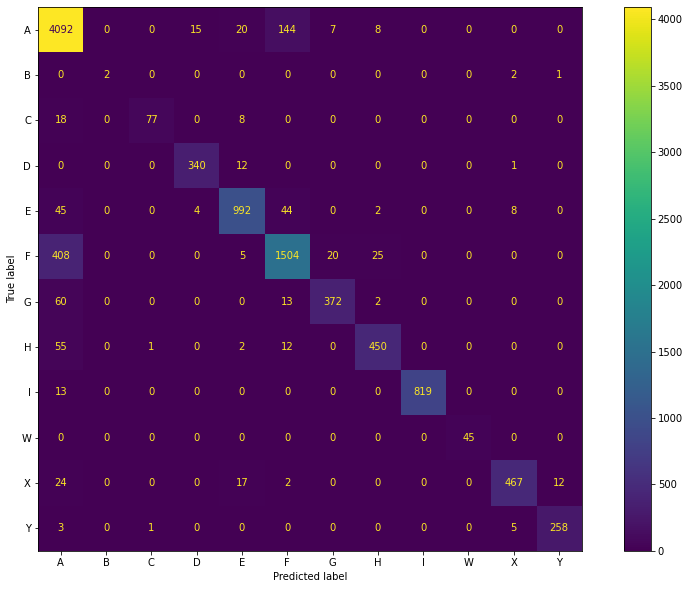

In [ ]:
cm=confusion_matrix(df_test.iloc[:,10],pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=xgb_with_hyper.classes_)
disp.plot()
plt.show()